In [4]:
# IMPORT LIBRARIES

from scipy import stats
import galpy.potential
from galpy.orbit import Orbit
from astropy import units as u
from galpy.potential import LogarithmicHaloPotential
import numpy as np
from galpy.potential import MWPotential2014,PowerSphericalPotential
import matplotlib.pyplot as plt
import astropy.units as u
from orbit_functions import *
import pickle
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from scipy.ndimage import gaussian_filter
from galpy.potential import plotRotcurve
from functools import partial
from scipy.fft import *
from scipy import interpolate, optimize
from astropy.io import fits
from astropy.table import Table
import emd


# DATA LOADER

class Loader():
    o_cache = None
    o_cache_name = None
    oo = None
    new = False

    def load_model(self, model, time, xmin=1000, xmax=3000, phi_range=0.2, maxvr=20):
        if model == 'MW_Sgr':
            Rmax=16.
            snap=str(int(np.round(time*100))) if time>=1 else '0'+str(int(time*100))
            df = Table.read('MW_Sgr/disk'+snap+'.fits', format='fits').to_pandas()
            df['X'],df['Y'],df['Z'],df['VX'],df['VY'],df['VZ']=cyl2cart(df['R'],df['phi'],df['Z'],df['VR'],df['Vphi'],df['VZ'])
            ind=df['R']<Rmax
            df=df[ind]    
            x,y,z,VR,Vphi,VZ,R,phi=df['X'],df['Y'],df['Z'],df['VR'],df['Vphi'],df['VZ'],df['R'],df['phi']
            Vphi=Vphi*-1.
            Lz=R*Vphi
        else:
            if self.o_cache_name == model:
                o = self.o_cache
            else:
                file='o_galpy/o_'+model+'.pkl'
                with open(file, 'rb') as f:#for orbits after perturbation
                    o = pickle.load(f)
                self.o_cache = o
                self.o_cache_name = model

            t=time*u.Gyr
            x=o.x(t)
            y=-o.y(t)#in galpy, orbits turn counterclockwise. changing sign of y we turn it into clockwise
            VR=o.vr(t)
            Vphi=o.vphi(t)*o.r(t)
            R=o.r(t)
            Lz=R*Vphi
            phi=o.phi(t)

        indphi=(np.abs(phi)>np.pi-phi_range)&(np.abs(phi)<np.pi+phi_range)
        x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
        indphi=(np.abs(VR)<maxvr)&(Lz>xmin)&(Lz<xmax)
        x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
        DATA = False
        
        return x,y,VR,Vphi,R,Lz,phi

    def load_data(self, xmin=1500, xmax=3500, phi_range=0.4, new=False):
        if self.oo == None or self.new != new:
            self.new = new
            path = 'o_galpy/SoS_SH_Gaia_test_GAL6D.fits'
            if new:
                path = 'o_galpy/DR3_SH_ruwe14_fidelity05_pioe5_GAL6D.fits'
            self.oo = Table.read(path, format='fits')
        oo = self.oo

        VR,Vphi,VZ,x,y,Z,R,phi=np.array((oo['VR'],oo['Vphi'],oo['VZ'],oo['X'],oo['Y'],oo['Z'],oo['R'],oo['phi']))
        Lz=-oo['Vphi']*oo['R']
        phi=-np.deg2rad(phi)
        Vphi=-Vphi
        
        indphi = abs(phi) < phi_range
        x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
        indphi=(Lz>xmin)&(Lz<xmax)
        x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
        
        DATA = True
        return x,y,VR,Vphi,R,Lz,phi

# Initialize data loader
l = Loader()


# AUXILIARY FUNCTIONS

# Group the data into bins in x and get the average y for each bin
def smooth_bins(x, y, xmin, xmax, binsize):
    binsLZ=np.arange(xmin,xmax,binsize)
    m,xedge,binnumber=stats.binned_statistic(x, y, statistic='mean', bins=[binsLZ]) 
    nx = np.arange(xmin-binsize/2, xmax, binsize)
    xpol = nx + binsize/2
    means = []
    for k in nx:
        rel = y[(k<x) & (x<k+binsize)]
        if len(rel) == 0:
            means.append(means[-1])
        else:
            means.append(np.mean(rel))
    ypol = np.array(means)
    return xpol, ypol

# Get an equispaced curve from a number of points
def curve_from_bins(nx, ny, N):
    f = interpolate.interp1d(nx, ny, kind='linear')
    xpol = np.linspace(nx[0], nx[-1], N)
    ypol = f(xpol)
    xpol = xpol[~np.isnan(ypol)]
    ypol = ypol[~np.isnan(ypol)]
    return xpol, ypol

# Perform Fourier transform on a curve
def fourier_from_curve(xpol, ypol):
    N = len(xpol)
    ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
    yf = fft(ypol)
    xf = fftfreq(N)
    yf = yf[xf>0]
    xf = xf[xf>0]
    xfr = ((xpol[-1]-xpol[0]) / abs(xf * N))
    return xfr, yf

/home/hpc/anaconda3/lib/python3.9/site-packages/astropy/table/table.py:3488: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other

0 23.014976990896646
1 118.18921748933828
2 225.56253967387326
3 679.9550675952473
4 48173.94554884991


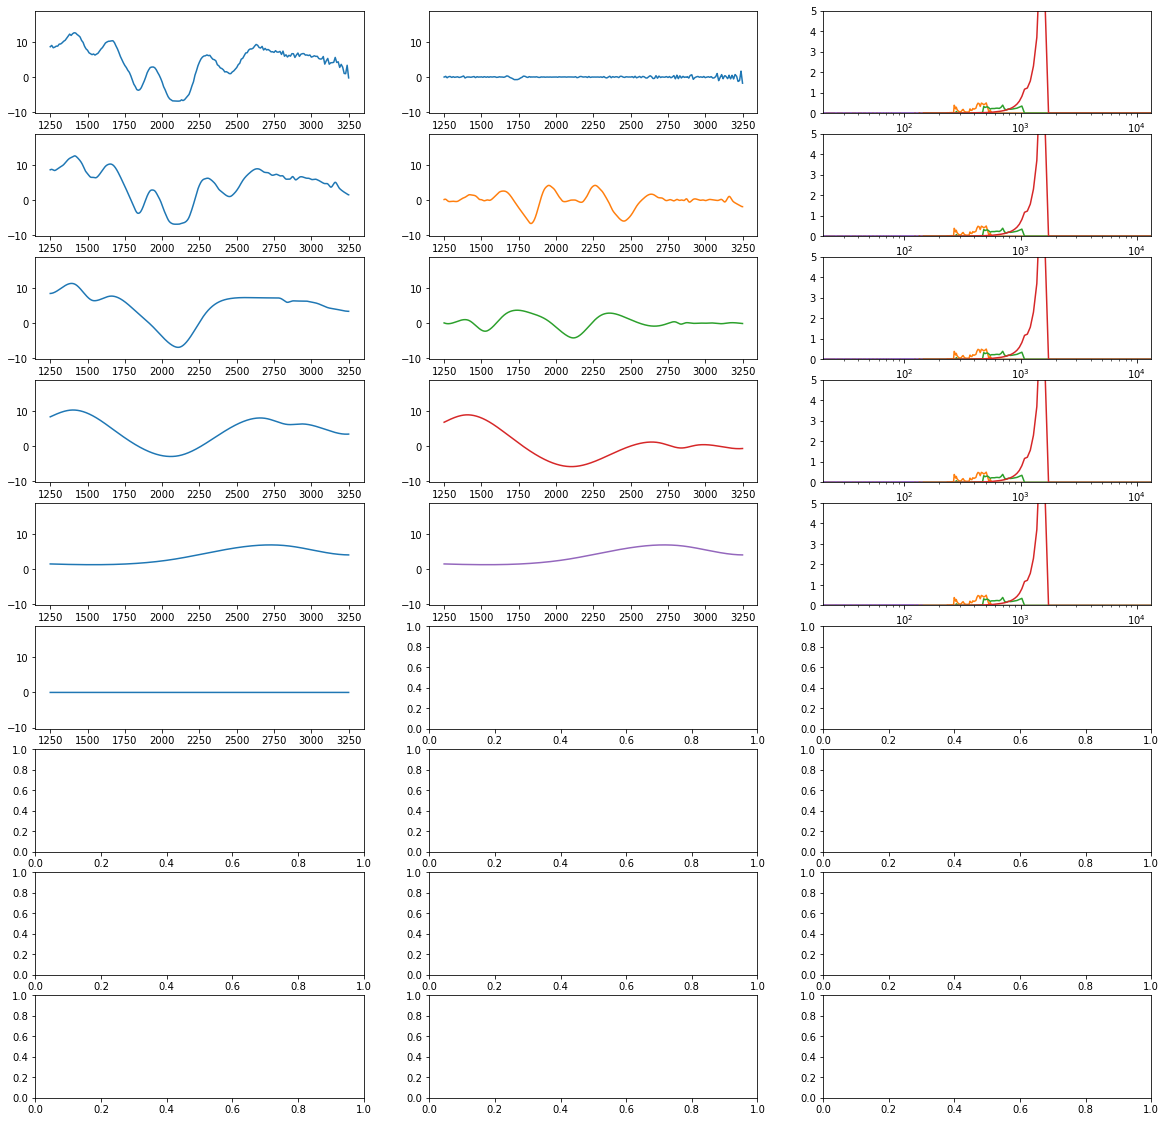

In [6]:
# Perform EMD on a model or on data and show each detected component.
# First column is the original curve and the results of successively substracting components, second column are the
# components, and third column is the instantaneous frequency of each component.

TIME = 1.5
XMIN=1200
XMAX=3500
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_model('Dhot_log', TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)
DATA = False

#TIME = 2.9
#XMIN=1000
#XMAX=3500
#BINSIZE = 10
#x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)
#DATA = False
#
XMIN=1250
XMAX=3250
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2, new=True)
DATA = True


fig, ax = plt.subplots(9,3,figsize=(20,20))


nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
N = 100000
xpol, ypol = curve_from_bins(nx, ny, N)
#nx, ny = smooth_bins(1/Lz, VR/Lz, 1/XMAX, 1/XMIN, 1e-6)
ax[0][0].plot(nx, ny)
ax[0][0].set_ylim(min(ny)*1.5, max(ny)*1.5)

#xfr = ((nx[-1]-nx[0]) / abs(xf * N))

sample_rate=1
imf = emd.sift.sift(ypol)
#IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')
rypol = ypol.copy()
for i in range(imf.shape[1]):
    ax[i][1].plot(xpol, imf[:,i], c=f'C{i}')
    ax[i][1].set_ylim(min(ypol)*1.5, max(ypol)*1.5)
    #ax[i][2].plot(xpol, IF[:,i])
    print(i, (nx[-1]-nx[0]) / abs(np.mean(IF[:,i]) * N))
    rypol -= imf[:,i]
    ax[i+1][0].plot(xpol, rypol)
    ax[i+1][0].set_ylim(min(ypol)*1.5, max(ypol)*1.5)
    for j in range(imf.shape[1]):
        freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 1000, 'linear')
        hht_f, spec = emd.spectra.hilberthuang(IF[:,j], IA[:,j], freq_edges, scaling='density')
        #hht_f, spec = emd.spectra.hilberthuang(IF[:,j], np.ones(IA[:,j].shape), freq_edges, scaling='density')
        hhtfr = ((nx[-1]-nx[0]) / (hht_f * N))
        ax[i][2].plot(hhtfr, spec)
        ax[i][2].xaxis.set_major_formatter(ticker.ScalarFormatter())
        ax[i][2].set_xlim(min(hhtfr), max(hhtfr))
        ax[i][2].set_xscale('log')
        ax[i][2].set_ylim(0,5)


/home/hpc/anaconda3/lib/python3.9/site-packages/astropy/table/table.py:3488: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other



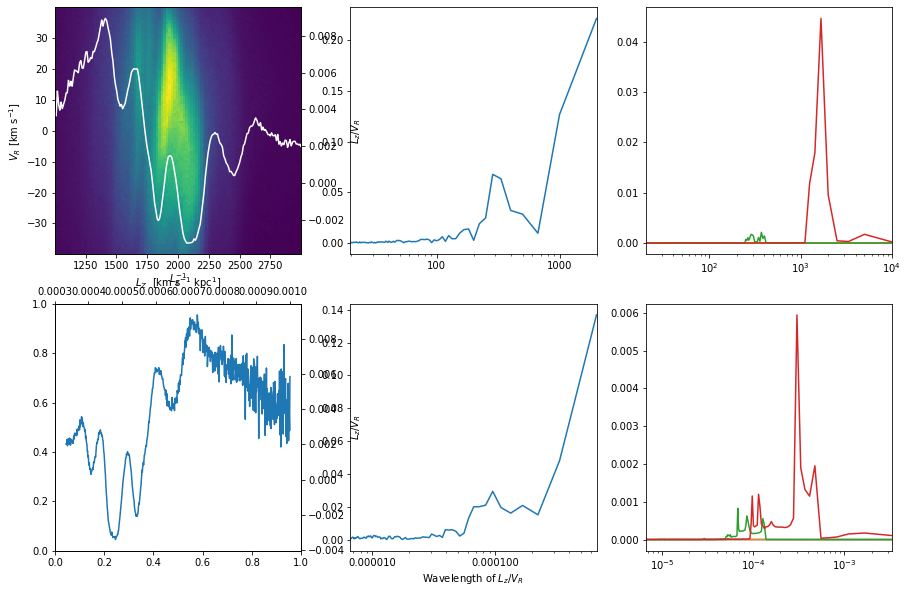

In [7]:
# Plot untransformed and transformed (with Lz**nexp) simulation data,
# their Fourier transforms and their Hilbert-Huang transforms (component-wise)

#TIME = 2.0
#XMIN=1200
#XMAX=3500
#BINSIZE = 10
#x,y,VR,Vphi,R,Lz,phi=l.load_model('Dhot_log', TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)
#DATA = False

#TIME = 2.9
#XMIN=1000
#XMAX=3500
#BINSIZE = 10
#x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)
#DATA = False

XMIN=1000
XMAX=3000
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2, new=True)
DATA = True

fig, ax = plt.subplots(2,3,figsize=(15,10))

nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
N = 100000
#f = interpolate.interp1d(nx, ny, kind='linear')
#xpol = np.linspace(nx[0], nx[-1], N)
#ypol = f(xpol)
ax[0][0].hist2d(Lz[abs(VR)<40], VR[abs(VR)<40], bins=100);
ax[0][0].set_aspect('auto')
ax[0][0].set_xlabel(r'$L_Z$  [km s$^{-1}$ kpc$^{1}$]')
ax[0][0].set_ylabel(r'$V_R$ [km s$^{-1}$] ')

nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
N = 100000
P = 1
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
ax_right = ax[0][0].twinx()
ax_right.plot(xpol, ypol, c='white')
ax_right.set_ylabel('$L_z/V_R$')

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol)
xf = fftfreq(N)
yf = yf[xf>0]
xf = xf[xf>0]

xfr = ((nx[-1]-nx[0]) / abs(xf * N))
ax[0][1].plot(xfr, np.abs(yf)/np.sum(np.abs(yf)))
ax[0][1].set_xlim(xfr[100], max(xfr))
ax[0][1].set_xscale('log')
ax[0][1].xaxis.set_major_formatter(ticker.ScalarFormatter())
ax[0][1].set_aspect('auto')

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
sample_rate=1
imf = emd.sift.sift(ypol)
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')
freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 500, 'linear')
#freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 50, 'log')

for i in range(4):
    hht_f, spec = emd.spectra.hilberthuang(IF[:,i], IA[:,i], freq_edges, scaling='density')
    hhtfr = ((nx[-1]-nx[0]) / (hht_f * N))
    ax[0][2].plot(hhtfr, spec)
    ax[0][2].xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax[0][2].set_xlim(min(hhtfr), max(hhtfr))
    ax[0][2].set_xscale('log')


nx, ny = smooth_bins(1/Lz, VR/Lz, np.min(1/Lz), np.max(1/Lz), 1e-6)
N = 100000
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
ax_right = ax[1][0].twiny()
ax_right.set_xlabel('$L_z^{-1}$')
ax_right = ax_right.twinx()
ax_right.plot(xpol, ypol)
ax_right.set_ylabel('$L_z/V_R$')

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol)
xf = fftfreq(N)
yf = yf[xf>0]
xf = xf[xf>0]

xfr = ((nx[-1]-nx[0]) / abs(xf * N))
ax[1][1].plot(xfr, np.abs(yf)/np.sum(np.abs(yf)))
ax[1][1].set_xlim(xfr[100], max(xfr))
ax[1][1].set_xscale('log')
ax[1][1].xaxis.set_major_formatter(ticker.ScalarFormatter())
ax[1][1].set_aspect('auto')
ax[1][1].set_xlabel('Wavelength of $L_z/V_R$')

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
sample_rate=1
imf = emd.sift.sift(ypol)
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')
freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 500, 'linear')
#freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 50, 'log')
hht_f, spec = emd.spectra.hilberthuang(IF, IA, freq_edges, scaling='density')
hhtfr = ((nx[-1]-nx[0]) / (hht_f * N))
#ax[1][2].plot(hhtfr, spec)
#ax[1][2].xaxis.set_major_formatter(ticker.ScalarFormatter())
#ax[1][2].set_xlim(min(hhtfr), max(hhtfr))
#ax[1][2].set_xscale('log')

for i in range(4):
    hht_f, spec = emd.spectra.hilberthuang(IF[:,i], IA[:,i], freq_edges, scaling='density')
    hhtfr = ((nx[-1]-nx[0]) / (hht_f * N))
    ax[1][2].plot(hhtfr, spec)
    ax[1][2].xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax[1][2].set_xlim(min(hhtfr), max(hhtfr))
    ax[1][2].set_xscale('log')


/home/hpc/anaconda3/lib/python3.9/site-packages/astropy/table/table.py:3488: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other



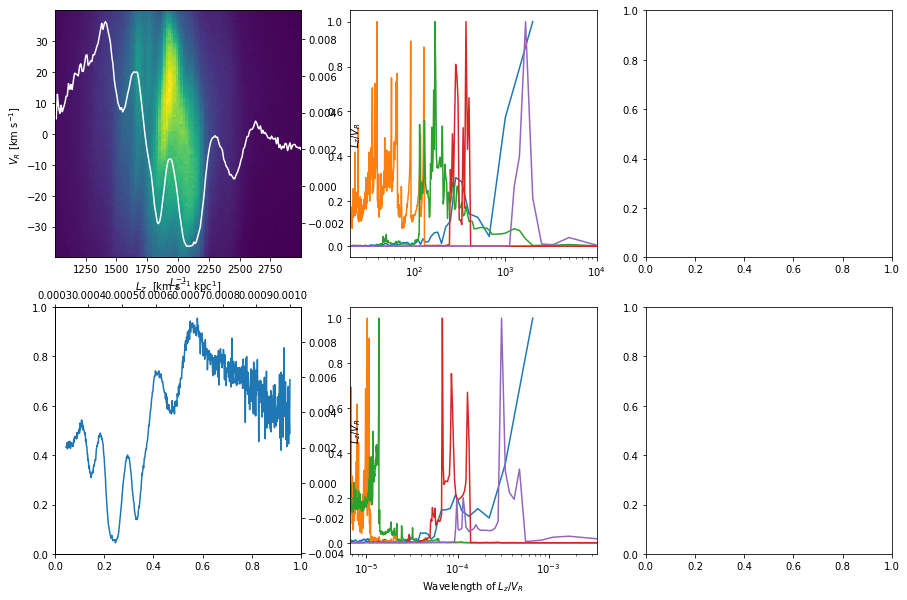

In [8]:
# Plot untransformed and transformed (with Lz**nexp) simulation data,
# and their Hilbert-Huang transforms normalized by component

#TIME = 2.0
#XMIN=1200
#XMAX=3500
#BINSIZE = 10
#x,y,VR,Vphi,R,Lz,phi=l.load_model('Dhot_log', TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)
#DATA = False

#TIME = 2.9
#XMIN=1000
#XMAX=3500
#BINSIZE = 10
#x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)
#DATA = False

XMIN=1000
XMAX=3000
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2, new=True)
DATA = True

fig, ax = plt.subplots(2,3,figsize=(15,10))

nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
N = 100000
#f = interpolate.interp1d(nx, ny, kind='linear')
#xpol = np.linspace(nx[0], nx[-1], N)
#ypol = f(xpol)
ax[0][0].hist2d(Lz[abs(VR)<40], VR[abs(VR)<40], bins=100);
ax[0][0].set_aspect('auto')
ax[0][0].set_xlabel(r'$L_Z$  [km s$^{-1}$ kpc$^{1}$]')
ax[0][0].set_ylabel(r'$V_R$ [km s$^{-1}$] ')

nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
N = 100000
P = 1
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
ax_right = ax[0][0].twinx()
ax_right.plot(xpol, ypol, c='white')
ax_right.set_ylabel('$L_z/V_R$')

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol)
xf = fftfreq(N)
yf = yf[xf>0]
xf = xf[xf>0]

xfr = ((nx[-1]-nx[0]) / abs(xf * N))
ax[0][1].plot(xfr, np.abs(yf)/np.max(np.abs(yf)))
ax[0][1].set_xlim(xfr[100], max(xfr))
ax[0][1].set_xscale('log')
ax[0][1].xaxis.set_major_formatter(ticker.ScalarFormatter())
ax[0][1].set_aspect('auto')

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
sample_rate=1
imf = emd.sift.sift(ypol)
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')
freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 500, 'linear')
#freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 50, 'log')

for i in range(4):
    hht_f, spec = emd.spectra.hilberthuang(IF[:,i], IA[:,i], freq_edges, scaling='density')
    hhtfr = ((nx[-1]-nx[0]) / (hht_f * N))
    ax[0][1].plot(hhtfr, spec/np.max(spec))
    ax[0][1].xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax[0][1].set_xlim(min(hhtfr), max(hhtfr))
    ax[0][1].set_xscale('log')


nx, ny = smooth_bins(1/Lz, VR/Lz, np.min(1/Lz), np.max(1/Lz), 1e-6)
N = 100000
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
ax_right = ax[1][0].twiny()
ax_right.set_xlabel('$L_z^{-1}$')
ax_right = ax_right.twinx()
ax_right.plot(xpol, ypol)
ax_right.set_ylabel('$L_z/V_R$')

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol)
xf = fftfreq(N)
yf = yf[xf>0]
xf = xf[xf>0]

xfr = ((nx[-1]-nx[0]) / abs(xf * N))
ax[1][1].plot(xfr, np.abs(yf)/np.max(np.abs(yf)))
ax[1][1].set_xlim(xfr[100], max(xfr))
ax[1][1].set_xscale('log')
ax[1][1].xaxis.set_major_formatter(ticker.ScalarFormatter())
ax[1][1].set_aspect('auto')
ax[1][1].set_xlabel('Wavelength of $L_z/V_R$')

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
sample_rate=1
imf = emd.sift.sift(ypol)
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')
freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 500, 'linear')
#freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 50, 'log')
hht_f, spec = emd.spectra.hilberthuang(IF, IA, freq_edges, scaling='density')
hhtfr = ((nx[-1]-nx[0]) / (hht_f * N))
#ax[1][2].plot(hhtfr, spec)
#ax[1][2].xaxis.set_major_formatter(ticker.ScalarFormatter())
#ax[1][2].set_xlim(min(hhtfr), max(hhtfr))
#ax[1][2].set_xscale('log')

for i in range(4):
    hht_f, spec = emd.spectra.hilberthuang(IF[:,i], IA[:,i], freq_edges, scaling='density')
    hhtfr = ((nx[-1]-nx[0]) / (hht_f * N))
    ax[1][1].plot(hhtfr, spec/np.max(spec))
    ax[1][1].xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax[1][1].set_xlim(min(hhtfr), max(hhtfr))
    ax[1][1].set_xscale('log')


Dhot_log
Dhotn10_pn10
Dhotn_10_pn_10
Dhot_log_2perturb


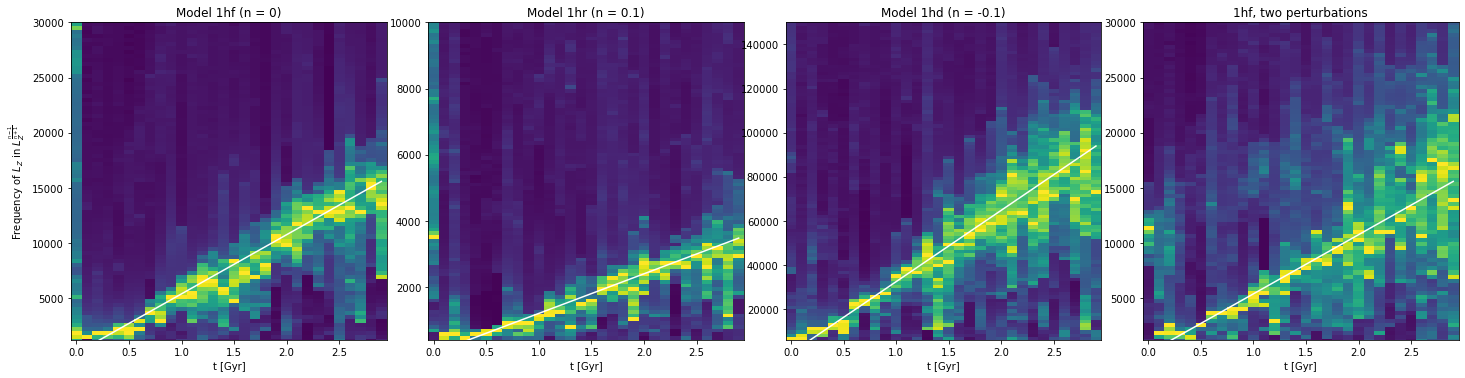

In [9]:
# Plot the evolution of the Hilbert-Huang transform of the simulations over time,
# and the frequency predicted by the theoretical formula

eps = 0.00001
times = np.arange(eps, 3.0+eps, 0.1)
vtimes = list(times)

fig, ax = plt.subplots(1,4,figsize=(20,5))
fig.tight_layout()

ns = [0,0.1,-0.1,0]
ylims=[30000,10000,150000,30000]
model_labels = ['Model 1hf (n = 0)', 'Model 1hr (n = 0.1)', 'Model 1hd (n = -0.1)', '1hf, two perturbations']
for model_i, model in enumerate(['Dhot_log', 'Dhotn10_pn10', 'Dhotn_10_pn_10', 'Dhot_log_2perturb']):
    print(model)
    fourier = []
    freqs = []
    freqs2 = []
    for time in times:
        XMIN=1200
        XMAX=3500
        BINSIZE = 10
        x,y,VR,Vphi,R,Lz,phi=l.load_model(model, time, xmin=XMIN, xmax=XMAX, phi_range=0.2)
        DATA = False

        n = ns[model_i]
        nx, ny = smooth_bins(Lz**((n-1)/(n+1)), VR/Lz, np.min(Lz**((n-1)/(n+1))), np.max(Lz**((n-1)/(n+1))), 1e-6)
        N = 100000
        f = interpolate.interp1d(nx, ny, kind='linear')
        xpol = np.linspace(nx[0], nx[-1], N)
        ypol = f(xpol)
        xpol = xpol[~np.isnan(ypol)]
        ypol = ypol[~np.isnan(ypol)]
        N = len(ypol)
        
        ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
        sample_rate=1
        imf = emd.sift.sift(ypol)
        
        IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')
        freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 500, 'linear')
        #freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 50, 'log')
        hht_f, spec = emd.spectra.hilberthuang(IF, IA, freq_edges, scaling='spectrum')
        spec = spec / np.max(spec)
        #hht_f, spec = emd.spectra.hilberthuang(IF, np.ones(IA.shape), freq_edges, scaling='spectrum')
        hhtfr = ((nx[-1]-nx[0]) / (hht_f * N))
        fourier.append(spec)
        
    fourier = np.array(fourier)
    xfr = hhtfr

    Z = fourier.T
    ax[model_i].pcolormesh(times, 1/xfr, np.sqrt(Z), cmap='viridis')
    ax[model_i].set_xlabel('t [Gyr]')
    ax[model_i].set_ylim(ylims[model_i]/25,ylims[model_i])
    ax[model_i].set_title(model_labels[model_i])
    ax[0].set_ylabel(r'Frequency of $L_Z$ in $L_Z^{\frac{n-1}{n+1}}$')
    
    def freqcurve(t, n):
        Vc = 240
        R0 = 8
        ct = (Vc / R0**n) ** (2/(1+n)) * (1-0.5*np.sqrt(2*n+2)) / np.pi
        return ct * t
    
    ax[model_i].plot(times, freqcurve(times, n=ns[model_i]), c='w')


In [10]:
# The same as the previous plot, but with the MW_Sgr simulation.
# Part 1: Process the data (takes a long time)

eps = 0.00001
times = np.arange(0.1, 7.0, 0.1)
vtimes = list(times)

binsizes = [10, 1e-6]
n = (-0.1-1)/(-0.1+1)
for tfi, tf in enumerate([lambda x: x, lambda x: x**n]):
    fourier = []
    freqs = []
    freqs2 = []
    for time in times:
        print(time)

        XMIN=1000
        XMAX=3500
        BINSIZE = 50
        x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', time, xmin=XMIN, xmax=XMAX, phi_range=0.2, maxvr=100)
        DATA = False

        nx, ny = smooth_bins(tf(Lz), VR/Lz, np.min(tf(Lz)), np.max(tf(Lz)), binsizes[tfi])
        N = 100000
        f = interpolate.interp1d(nx, ny, kind='linear')
        xpol = np.linspace(nx[0], nx[-1], N)
        ypol = f(xpol)
        xpol = xpol[~np.isnan(ypol)]
        ypol = ypol[~np.isnan(ypol)]
        N = len(ypol)

        ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
        sample_rate=1
        imf = emd.sift.sift(ypol)
        IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')
        freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 200, 'linear')
        #freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 50, 'log')
        hht_f, spec = emd.spectra.hilberthuang(IF, IA, freq_edges, scaling='spectrum')
        #hht_f, spec = emd.spectra.hilberthuang(IF, np.ones(IA.shape), freq_edges, scaling='spectrum')
        hhtfr = ((nx[-1]-nx[0]) / (hht_f * N))
        fourier.append(spec)

    np.save(f'hht_time_mwsgr_10_35_{tfi}.npy', fourier)
    np.save(f'hhfr_time_mwsgr_10_35_{tfi}.npy', hhtfr)


0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3000000000000003
1.4000000000000001
1.5000000000000002
1.6
1.7000000000000002
1.8000000000000003
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5000000000000004
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0000000000000004
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5000000000000004
3.6
3.7
3.8000000000000003
3.9000000000000004
4.0
4.1
4.2
4.3
4.3999999999999995
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3000000000000003
1.4000000000000001
1.5000000000000002
1.6
1.7000000000000002
1.8000000000000003
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5000000000000004
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0000000000000004
3.1
3.2
3.3000000000000003
3.4000000000000004
3.50000000000000

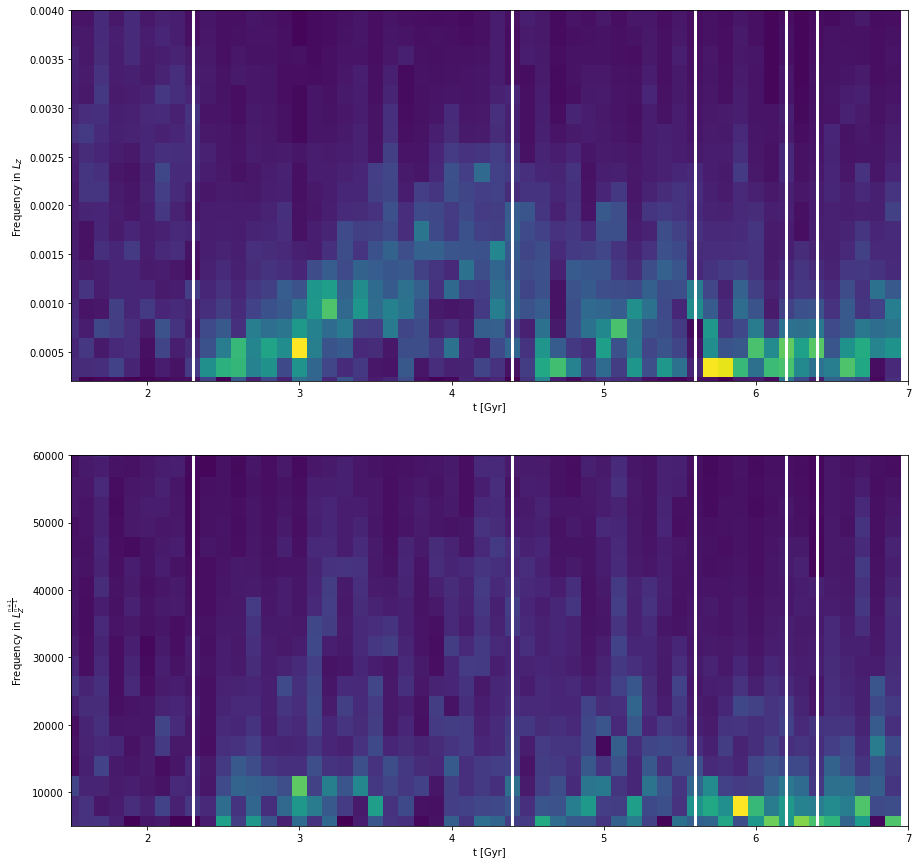

In [11]:
# Part 2: Make the plot

fig, ax = plt.subplots(2,1,figsize=(15,15))
times = np.arange(0.1, 7.0, 0.1)
ylims = [[0.00020,0.004], [5000,60000]]
desc = ["L_Z", r"L_Z^{\frac{n+1}{n-1}}"]
for tfi in range(2):
    fourier = np.load(f'hht_time_mwsgr_10_35_{tfi}.npy')
    xfr = np.load(f'hhfr_time_mwsgr_10_35_{tfi}.npy')
    fourier = np.abs(np.array(fourier))
    xfr = xfr[:100]
    fourier = fourier[:,:100]

    Z = fourier.T
    ax[tfi].pcolormesh(times, 1/xfr, np.sqrt(Z), cmap='viridis')
    ax[tfi].set_xlabel('t [Gyr]')
    ax[tfi].set_ylabel(fr'Frequency in ${desc[tfi]}$')
    ax[tfi].set_ylim(*ylims[tfi])
    ax[tfi].set_xlim(1.5,7)
    
    for peri in [2.3, 4.4, 5.6, 6.2, 6.4]:
        ax[tfi].axvline(peri, c='w', lw=3)
